In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics

In [24]:
data = pd.read_csv('Datas/DataTreinamentoDevAcademy/data_1__.csv', date_parser = 'data')
data_test = pd.read_csv('Datas/DataTreinamentoDevAcademy/data_1__test.csv', date_parser = 'data')
data.head(20)

,index,data,valor
0,0,2016-08-29,9.00
1,1,2016-08-30,1.60
2,2,2016-08-31,15311.70
3,3,2016-09-01,13932.67
4,4,2016-09-02,11535.45
5,5,2016-09-03,25864.32
6,6,2016-09-04,161344.35
7,7,2016-09-07,46380.31
8,8,2016-09-08,7341.94
9,9,2016-09-09,20184.57


In [3]:
data_test.head()

,index,data,valor
0,568,2018-10-03,15895.50
1,569,2018-10-04,9273.00
2,570,2018-10-05,16079.25
3,571,2018-10-06,29740.60
4,572,2018-10-07,45392.70


In [4]:
data['data'] = data['data'].astype('datetime64[ns]')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568 entries, 0 to 567
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   568 non-null    int64         
 1   data    568 non-null    datetime64[ns]
 2   valor   568 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 13.4 KB


In [5]:
data.tail()

,index,data,valor
563,563,2018-09-26,13598.15
564,564,2018-09-27,9937.20
565,565,2018-09-28,21288.81
566,566,2018-09-29,20712.30
567,567,2018-09-30,85709.60


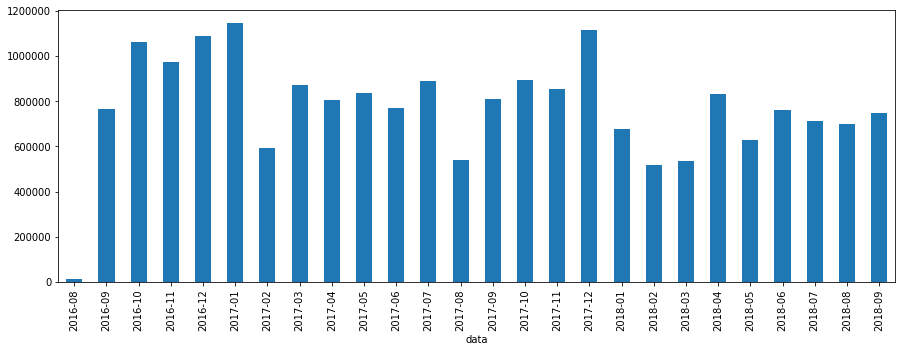

In [6]:
data['valor'].groupby(data['data'].dt.to_period('M')).sum().plot(kind='bar', figsize=(15,5))

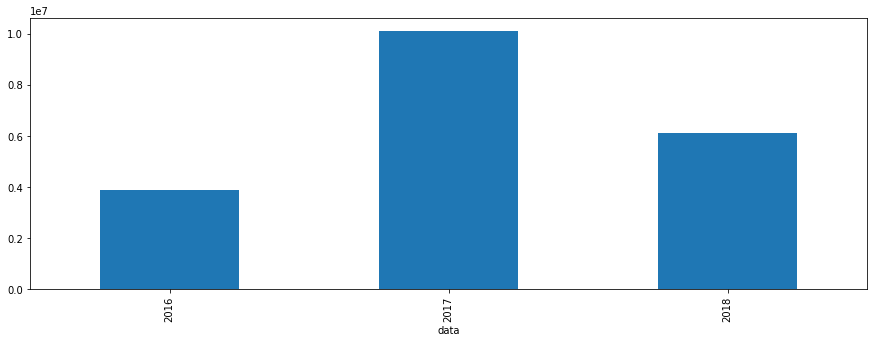

In [7]:
data['valor'].groupby(data['data'].dt.to_period('Y')).sum().plot(kind='bar', figsize=(15,5))

In [8]:
data_train = data[['valor']].values
#data_train = data.iloc[:, 2:3].values

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
data_train_scaled = scaler.fit_transform(np.array(data_train))

In [10]:
previsores = []
preco_real = []
for i in range(50, len(data)):
    previsores.append(data_train_scaled[i-50:i, 0])
    preco_real.append(data_train_scaled[i, 0])

In [11]:
previsores, preco_real = np.array(previsores), np.array(preco_real)

In [12]:
dt_values = pd.DataFrame(previsores)
dt_values[50] = pd.DataFrame(preco_real)
dt_values.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.000046,0.000008,0.077984,0.070960,0.058751,0.131729,0.821743,0.236219,0.037393,0.102802,...,0.093374,0.042952,0.116295,0.498731,0.595801,0.002453,0.062914,0.151674,0.049725,0.139186
1,0.000008,0.077984,0.070960,0.058751,0.131729,0.821743,0.236219,0.037393,0.102802,0.144439,...,0.042952,0.116295,0.498731,0.595801,0.002453,0.062914,0.151674,0.049725,0.139186,0.437463
2,0.077984,0.070960,0.058751,0.131729,0.821743,0.236219,0.037393,0.102802,0.144439,0.467046,...,0.116295,0.498731,0.595801,0.002453,0.062914,0.151674,0.049725,0.139186,0.437463,0.607409
3,0.070960,0.058751,0.131729,0.821743,0.236219,0.037393,0.102802,0.144439,0.467046,0.075565,...,0.498731,0.595801,0.002453,0.062914,0.151674,0.049725,0.139186,0.437463,0.607409,0.082986
4,0.058751,0.131729,0.821743,0.236219,0.037393,0.102802,0.144439,0.467046,0.075565,0.063390,...,0.595801,0.002453,0.062914,0.151674,0.049725,0.139186,0.437463,0.607409,0.082986,0.057892


In [13]:
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))
previsores.shape

(518, 50, 1)

### using RNN with keras for predict Time Series

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

Using TensorFlow backend.


In [15]:
regressor = Sequential()
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], 1)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

regressor.add(Dense(units = 1, activation = 'sigmoid'))

In [16]:
regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error',
                  metrics = ['mean_absolute_error'])

In [17]:
#es = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 10, verbose = 1)
#rlr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, verbose = 1)
#mcp = ModelCheckpoint(filepath = 'pesos.h5', monitor = 'loss', 
#                      save_best_only = True, verbose = 1)


In [18]:
regressor.fit(previsores, preco_real, epochs = 100, batch_size = 32)
              #callbacks = [es, rlr, mcp])

Epoch 1/100
518/518 [==============================] - 4s 7ms/step - loss: 0.0502 - mean_absolute_error: 0.1752
Epoch 2/100
518/518 [==============================] - 1s 3ms/step - loss: 0.0357 - mean_absolute_error: 0.1437
Epoch 3/100
518/518 [==============================] - 2s 3ms/step - loss: 0.0348 - mean_absolute_error: 0.1444
Epoch 4/100
518/518 [==============================] - 2s 3ms/step - loss: 0.0361 - mean_absolute_error: 0.1423
Epoch 5/100
518/518 [==============================] - 2s 3ms/step - loss: 0.0361 - mean_absolute_error: 0.1416
Epoch 6/100
518/518 [==============================] - 1s 3ms/step - loss: 0.0328 - mean_absolute_error: 0.1378
Epoch 7/100
518/518 [==============================] - 1s 3ms/step - loss: 0.0352 - mean_absolute_error: 0.1409
Epoch 8/100
518/518 [==============================] - 1s 3ms/step - loss: 0.0348 - mean_absolute_error: 0.1413
Epoch 9/100
518/518 [==============================] - 1s 3ms/step - loss: 0.0348 - mean_absolute_error:

518/518 [==============================] - 2s 4ms/step - loss: 0.0338 - mean_absolute_error: 0.1406
Epoch 74/100
518/518 [==============================] - 1s 2ms/step - loss: 0.0333 - mean_absolute_error: 0.1401
Epoch 75/100
518/518 [==============================] - 2s 4ms/step - loss: 0.0338 - mean_absolute_error: 0.1405
Epoch 76/100
518/518 [==============================] - 2s 4ms/step - loss: 0.0345 - mean_absolute_error: 0.1446
Epoch 77/100
518/518 [==============================] - 2s 4ms/step - loss: 0.0340 - mean_absolute_error: 0.1407
Epoch 78/100
518/518 [==============================] - 2s 4ms/step - loss: 0.0340 - mean_absolute_error: 0.1394
Epoch 79/100
518/518 [==============================] - 2s 3ms/step - loss: 0.0342 - mean_absolute_error: 0.1441
Epoch 80/100
518/518 [==============================] - 1s 3ms/step - loss: 0.0343 - mean_absolute_error: 0.1391
Epoch 81/100
518/518 [==============================] - 2s 4ms/step - loss: 0.0333 - mean_absolute_error: 0.1

In [19]:
data_total = pd.concat((data['valor'], data_test['valor']), axis = 0)
entradas = data_total[len(data_total) - len(data_test) - 50:].values
entradas = entradas.reshape(-1, 1)
entradas = scaler.transform(entradas)
preco_real_test = data_test[['valor']].values

In [20]:
X_teste = []
for i in range(50, (50+len(data_test))):
    X_teste.append(entradas[i-50:i, 0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))

In [21]:
previsoes = regressor.predict(X_teste)
previsoes = scaler.inverse_transform(previsoes)

previsoes.mean(), preco_real_test.mean()

(30143.887, 30263.337619047623)

In [22]:
previsoes

array([[30689.643],
       [30519.25 ],
       [30575.975],
       [30745.885],
       [30841.48 ],
       [30728.242],
       [30659.93 ],
       [30644.545],
       [30391.541],
       [30285.74 ],
       [29552.125],
       [29162.695],
       [29113.168],
       [29346.154],
       [29651.982],
       [29622.03 ],
       [29747.033],
       [30055.512],
       [30113.615],
       [30301.086],
       [30273.99 ]], dtype=float32)

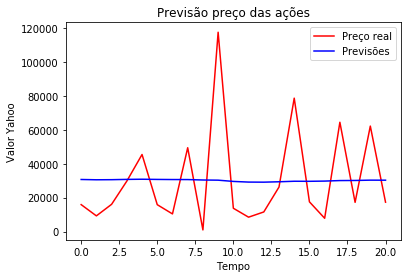

In [23]:
plt.plot(preco_real_test, color = 'red', label = 'Preço real')
plt.plot(previsoes, color = 'blue', label = 'Previsões')
plt.title('Previsão preço de arrecadação')
plt.xlabel('Tempo')
plt.ylabel('')
plt.legend()
plt.show()